# CNN 手写识别程序
从torchvision模块处torchvision.datasets.MNIST下载数据

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # 数据库模块
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1           # 训练整批数据多少次, 为了节约时间, 我们只训练一次
BATCH_SIZE = 50
LR = 0.001          # 学习率
DOWNLOAD_MNIST = True  # 如果你已经下载好了mnist数据就写上 False

# 训练数据
# Mnist 手写数字
train_data = torchvision.datasets.MNIST(
    root='./mnist/',    # 保存或者提取位置
    train=True,  # this is training data
    transform=torchvision.transforms.ToTensor(),    # 转换 PIL.Image or numpy.ndarray 成
                                                    # torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=DOWNLOAD_MNIST,          # 没下载就下载, 下载了就不用再下了
)


In [2]:
# 测试数据
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)

# 批训练 50samples, 1 channel, 28x28 (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# 为了节约时间, 我们测试时只测试前2000个
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]


# 构建CNN网络

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,      # input height
                out_channels=16,    # n_filters
                kernel_size=5,      # filter size
                stride=1,           # filter movement/step
                padding=2,      # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-1)/2 当 stride=1
            ),      # output shape (16, 28, 28)
            nn.ReLU(),    # activation
            nn.MaxPool2d(kernel_size=2),    # 在 2x2 空间里向下采样, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(  # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape (32, 14, 14)
            nn.ReLU(),  # activation
            nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   # 展平多维的卷积图成 (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output

cnn = CNN()
print(cnn)  # net architecture



CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


# 训练及测试下载的数据

In [4]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted

print(test_y[:10].numpy(), 'real number')     
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # 分配 batch data, normalize x when iterate train_loader
        output = cnn(b_x)               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        if step%100 == 0:                # 每5000个sample打印
            test_output = cnn(test_x[:10])
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            print(pred_y, 'prediction number')


[7 2 1 0 4 1 4 9 5 9] real number
[1 8 8 1 1 8 1 1 1 1] prediction number
[7 2 1 0 4 1 4 9 6 9] prediction number
[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 6 9] prediction number
[7 2 1 0 4 1 4 9 6 9] prediction number
[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] prediction number


# 显示测试数字的图片

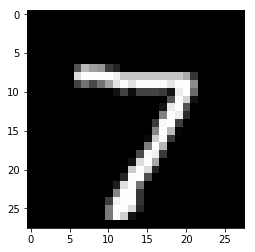

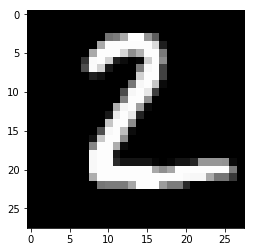

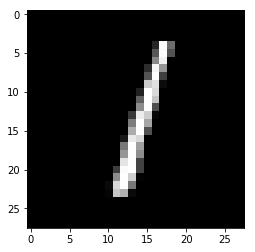

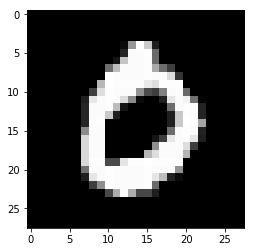

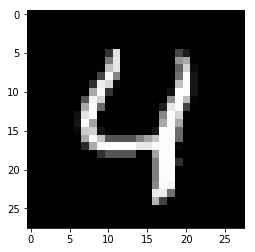

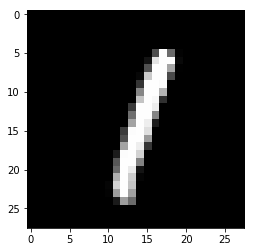

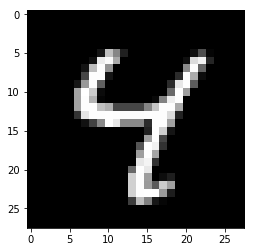

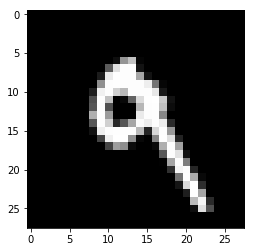

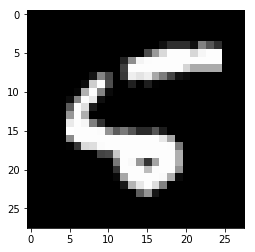

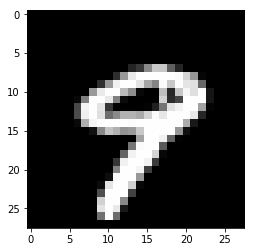

In [5]:
from PIL import Image
for x in range(10):
    num = test_x[x].numpy()*256
    img_b = Image.new("RGB",(28,28))#不指定color，则为黑色#000000
    for i in range(28):
        for j in range(28):
            img_b.putpixel((j,i),(num[0][i][j],num[0][i][j],num[0][i][j]))

    plt.imshow(img_b)
    plt.show()